- klue/roberta -> small, base, large
- klue/bert-base
- monologg/koelectra -> small, base / v2, v3
사용해보기

##  klue-roberta-model
- KLUE는 최초의 Korean Bench Mark Dataset으로 공식 github와 그에 대한 논문이 존재한다. 확인해본 결과, klue-roberta-model은 더 많은 데이터를 기반으로 학습하였으며 vocab size도 32,000여개로 충분하다.

In [ ]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# go to file
os.chdir('/content/drive/MyDrive/dacon')

In [ ]:
train = pd.read_csv("train_data.csv")
test= pd.read_csv("test_data.csv")
submission = pd.read_csv("sample_submission.csv")

In [ ]:
train[:10]

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
5,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment
6,6,자신뿐만 아니라 남을 돕고자 하는 청년의 꿈과 열정에 모두가 주목하고 있다.,모든 청년은 꿈과 열정을 가지고 있다.,neutral
7,7,시대상황을 고려하는 현명한 시청태도가 요구되다.,시청태도에 특별한 주의점은 없다.,contradiction
8,8,사진과 차이없는 아기자기한 실내소품들과 분위기가 멋졌습니다.,아기자기한 실내소품들은 사진에서 본 것과 차이가 있었습니다.,contradiction
9,9,"빠른 답장과 간편한 체크인, 깨끗한 집 좋았어요",체크인이 복잡했어요.,contradiction


In [ ]:
print(train.shape) #train 약 2만5천개
print(test.shape) # test 약 1천6백개
print(submission.shape)

(24998, 4)
(1666, 4)
(1666, 2)


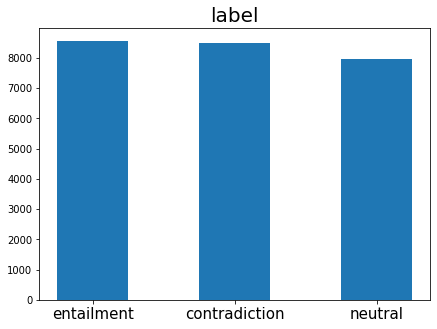

entailment       8561
contradiction    8489
neutral          7948
Name: label, dtype: int64


In [ ]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt 
# 데이터 분포 꽤나 balance !! 
feature = train['label']

plt.figure(figsize=(7,5)) 
plt.title('label', fontsize=20)
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize=15) 
plt.show()
print(temp) 

In [ ]:
print('Max Premise Length: ', np.max(train['premise'].str.len()))  #전제 최대는 90자, 최소는 19자
print('Min Premise Length: ', np.min(train['premise'].str.len()))
print('Mean Premise Lenght: ',np.mean(train['premise'].str.len()), '\n')

print('Max Hypothesis Length: ', np.max(train['hypothesis'].str.len()))  #가설 최대는 103자, 최소는 5자
print('Min Hypothesis Length: ', np.min(train['hypothesis'].str.len()))
print('Mean Hypothesis Lenght: ',  np.mean(train['hypothesis'].str.len())

Max Premise Length:  90
Min Premise Length:  19
Mean Premise Lenght:  45.406552524201935 

Max Hypothesis Length:  103
Min Hypothesis Length:  5
Mean Hypothesis Lenght:  24.924433954716378


- 특수문자나 영어 거의 없음

In [ ]:
!pip install transformers

In [ ]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

- SEED 고정, GPU설정

In [ ]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## klue/roberta-large
- https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/18.%20Fine-tuning%20BERT%20with%20different%20tasks/18-5.%20kor_bert_kornli_model_from_transformers_tpu.ipynb 참고

In [ ]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("klue/roberta-large")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

In [ ]:
# SPLIT 
train, val = train_test_split(train, test_size=0.2, random_state=2021)

In [ ]:
train.head()

,index,premise,hypothesis,label
10072,10072,이번 비자림로 공사 논란은 대한민국 정부의 환경에 대한 인식 부족과 암암리에 이뤄진...,환경 상태에 대해 대한민국 정부는 확실히 자각하고 있었다.,contradiction
13198,13198,이 영화는 가장 훌륭한 인생 지침서라고 생각한다,이 영화는 최악의 인생 지침서라고 생각한다.,contradiction
20677,20677,"또 모범음식점의 경우 1년 거치 2년 균등분할 상환조건으로 최대 3,000만원까지 ...","1년 거치 2년 균등분할 상환 조건에 맞으면 모범음식점은 3,000만원까지 운영자금...",entailment
15158,15158,고전 발레의 의상이 현재처럼 통일된 것은 거의 19세기의 전기부터이다.,고전 발레의 의상은 현재처럼 통일된 것은 정확히 1857년부터이다.,neutral
11073,11073,임형빈 같은 사랑이 있을 수는 있다.,임형빈 같은 사랑이 있을 가능성은 있다.,entailment


In [ ]:
val.head()

,index,premise,hypothesis,label
13893,13893,유럽에서 발생한 일련의 폭탄 테러가 팔레스타인 혁명군의 소행이라고 결론내린 쿠르츠는...,팔레스타인에서 폭탄 테러가 발생한다.,contradiction
23917,23917,비행기는 독일 함대의 폭격을 받아 바다에 추락하게 된다.,추락한 비행기는 대한항공 007편이다.,neutral
8539,8539,그당시에 프레데터의 성격 관습 문화등을 이 영화한편으로 다표헌한것같다,이 영화 한 편이 프레데터의 특징을 다 나타냈다.,entailment
20886,20886,지하철역에서 접근하기 좋은 아파트였습니다.,지하철역에서 아파트까지 접근하기 좋았습니다.,entailment
7779,7779,18일 엘렌 페이지는 인스타그램에 한 남성 배우 사진을 게재했다.,엘렌 페이지는 인스타그램을 한다.,entailment


In [ ]:
test.head()

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer


In [ ]:
import urllib.request
from sklearn import preprocessing
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
config = AutoConfig.from_pretrained('klue/roberta-large')
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained('klue/roberta-large', config=config)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'cl

In [ ]:
max_seq_len = 128  # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음

In [ ]:
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids = [], [], []

    for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1)):
        encoding_result = tokenizer.encode_plus(sent1, sent2, max_length=max_seq_len, pad_to_max_length=True)

        input_ids.append(encoding_result['input_ids'])
        attention_masks.append(encoding_result['attention_mask'])
        token_type_ids.append(encoding_result['token_type_ids'])

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    return (input_ids, attention_masks, token_type_ids)

In [ ]:
X_train = convert_examples_to_features(train['premise'], train['hypothesis'],  max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/19998 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 19998/19998 [00:04<00:00, 4993.79it/s]


In [ ]:
# 최대 길이: 128
input_id = X_train[0][0]
attention_mask = X_train[1][0]
token_type_id = X_train[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    0  3686 10009  2323  2200  4079  4496  2073  4892  3659  2079  3828
  2170  3618  4263  4245  2145  1383 26121  2170  8815  6307 19798  2079
  7808  2138 18573   575  2052   861   575 28674    18     2  3828  3889
  2170  3643  4892  3659  2259  6768 12934 19521  1513  2359  2062    18
     2     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
X_valid = convert_examples_to_features(val['premise'], val['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 5000/5000 [00:00<00:00, 6409.30it/s]


In [ ]:
X_test = convert_examples_to_features(test['premise'], test['hypothesis'],max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/1666 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 1666/1666 [00:00<00:00, 6557.99it/s]


In [ ]:
train_label = train['label'].tolist()
val_label = val['label'].tolist()
test_label = test['label'].tolist()

In [ ]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

y_train = idx_encode.transform(train_label) # 주어진 고유한 정수로 변환
y_val = idx_encode.transform(val_label) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
idx_label = {value: key for key, value in label_idx.items()}
print(label_idx)
print(idx_label)

{'contradiction': 0, 'entailment': 1, 'neutral': 2}
{0: 'contradiction', 1: 'entailment', 2: 'neutral'}


In [ ]:
from transformers import TFBertForSequenceClassification

### [TRY 1] 제공된 BASELINE모델로 돌리기 -> 정확도 약 0.3점대
### [TRY 2] 모델 파라미터 수정 + dropout, adamdecay
- https://dacon.io/competitions/official/235747/codeshare/3054?page=1&dtype=recent 뉴스토픽대회 코드 참고

In [ ]:
model_name = "'klue/roberta-large'"

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import TruncatedNormal
from transformers import TFAutoModel

class Klue_RobertaClassifier(Model):
    def __init__(self, model_name):
        super(Klue_RobertaClassifier, self).__init__()
        self.bert = TFAutoModel.from_pretrained("klue/roberta-large", num_labels=3, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.classifier = Dense(3, kernel_initializer=TruncatedNormal(0.02),activation='softmax') #가중치 초기화, 활성화함수

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        input_ids, attention_mask, token_type_ids=inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        prediction = self.classifier(pooled_output)

        return prediction

In [ ]:
   # def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        # outputs value : sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

In [ ]:
model = Klue_RobertaClassifier("klue/roberta-large")  #dropout=0.5까지

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream 

In [ ]:
from transformers import AdamWeightDecay
optimizer = AdamWeightDecay(1e-5, weight_decay_rate=1e-4)  #과적합 방지
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
#model.compile(optimizer=optimizer, loss=model.compute_loss, metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)

model.fit(
    X_train, y_train, epochs=3, batch_size=8, validation_data=(X_valid, y_val),
    callbacks = [early_stopping])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.8276

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2500/2500 [==============================] - 1973s 789ms/step - loss: 0.4518 - accuracy: 0.8276 - val_loss: 0.3055 - val_accuracy: 0.8960
Epoch 2/3
2500/2500 [==============================] - 1994s 797ms/step - loss: 0.2084 - accuracy: 0.9282 - val_loss: 0.2946 - val_accuracy: 0.9034
Epoch 3/3
2500/2500 [==============================] - 1982s 793ms/step - loss: 0.1136 - accuracy: 0.9635 - val_loss: 0.3793 - val_accuracy: 0.9026


In [ ]:
pred = model.predict(X_test)

In [ ]:
pred.shape


(1666, 3)

In [ ]:
result = [np.argmax(val) for val in pred]

In [ ]:
out = [list(label_idx.keys())[_] for _ in result]
out[:3]

['contradiction', 'neutral', 'entailment']

In [ ]:
out = [list(label_idx.keys())[_] for _ in pred_labels ]
out[:3]

['contradiction', 'neutral', 'neutral']

In [ ]:
test['label'] = out
test[:20]

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,neutral
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,contradiction
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,contradiction
5,5,마지막에 존트라볼타 지하철에서 혼자 담배 무는 장면 압권이네요.,존트라볼타 지하철에서는 원칙상 담배를 피면 안된다.,contradiction
6,6,18일 귀국이라 발인도 지켜드리지 못해 더욱 죄송할 따름입니다.,18일 배를 타고 여행을 떠났습니다.,neutral
7,7,2003년 변정수 씨가 교통사고로 죽었다는 이야기가 돌았지만 사실무근이었다.,2003년 변정수 씨는 교통사고를 당했다.,entailment
8,8,성룡의 초기 전성기를 만들어준 또 하나의 역작,성룡은 초기에 전성기를 맞았다.,entailment
9,9,2015년 10월 임관해 사건 당시 대위였던 손씨는 수개월 뒤인 2018년 7월에 ...,손씨가 전역한 이후에 사건이 일어났다.,neutral


In [ ]:
test['label'].value_counts() 

neutral          590
contradiction    589
entailment       487
Name: label, dtype: int64

In [ ]:
submission['label']=out
submission.to_csv("klue-roberta-large-model시도1.csv", index=False)  #0.835